# Visualizing what happens in Union master
One disadvantage to collecting all the simulation in the Union_master component, is that it is not possible to insert monitors between the parts to check on the beam. This issue is addressed by adding logger components that can record scattering and absorption events that occurs during the simulation. This notebook will show examples on the usage of loggers and their features.

### Set up materials and geometry to investigate
First we set up the same mock cryostat we created in the advanced geometry tutorial to have an interesting system to investigate using the loggers.

In [1]:
from mcstasscript.interface import instr, functions, plotter
instrument = instr.McStas_instr("python_tutorial", input_path="run_folder")

In [2]:
Al_inc = instrument.add_component("Al_inc", "Incoherent_process")
Al_inc.sigma = 0.0082
Al_inc.unit_cell_volume = 66.4

Al_pow = instrument.add_component("Al_pow", "Powder_process")
Al_pow.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_inc,Al_pow"'
Al.my_absorption = 100*0.231/66.4 # barns [m^2 E-28]*Å^3[m^3 E-30]=[m E-2], factor 100

Sample_inc = instrument.add_component("Sample_inc", "Incoherent_process")
Sample_inc.sigma = 3.4176
Sample_inc.unit_cell_volume = 1079.1

Sample_pow = instrument.add_component("Sample_pow", "Powder_process")
Sample_pow.reflections = '"Na2Ca3Al2F14.laz"'

Sample = instrument.add_component("Sample", "Union_make_material")
Sample.process_string = '"Sample_inc,Sample_pow"'
Sample.my_absorption = 100*2.9464/1079.1

src = instrument.add_component("source", "Source_div")
src.xwidth = 0.01
src.yheight = 0.035
src.focus_aw = 0.01
src.focus_ah = 0.01
src.lambda0 = instrument.add_parameter("wavelength", value=5.0,
                                       comment="Wavelength in [Ang]")
src.dlambda = "0.01*wavelength"
src.flux = 1E13

sample_geometry = instrument.add_component("sample_geometry", "Union_cylinder")
sample_geometry.yheight = 0.03
sample_geometry.radius = 0.0075
sample_geometry.material_string='"Sample"' 
sample_geometry.priority = 100
sample_geometry.set_AT([0,0,1], RELATIVE=src)

container = instrument.add_component("sample_container", "Union_cylinder")
container.set_RELATIVE(sample_geometry)
container.yheight = 0.03+0.003 # 1.5 mm top and button
container.radius = 0.0075 + 0.0015 # 1.5 mm sides of container
container.material_string='"Al"' 
container.priority = 99

container_lid = instrument.add_component("sample_container_lid", "Union_cylinder")
container_lid.set_AT([0, 0.0155, 0], RELATIVE=container)
container_lid.yheight = 0.004
container_lid.radius = 0.013
container_lid.material_string='"Al"' 
container_lid.priority = 98

inner_wall = instrument.add_component("cryostat_wall", "Union_cylinder")
inner_wall.set_AT([0,0,0], RELATIVE=sample_geometry)
inner_wall.yheight = 0.12
inner_wall.radius = 0.03
inner_wall.material_string='"Al"' 
inner_wall.priority = 80

inner_wall_vac = instrument.add_component("cryostat_wall_vacuum", "Union_cylinder")
inner_wall_vac.set_AT([0,0,0], RELATIVE=sample_geometry)
inner_wall_vac.yheight = 0.12 - 0.008
inner_wall_vac.radius = 0.03 - 0.002
inner_wall_vac.material_string='"Vacuum"' 
inner_wall_vac.priority = 81

outer_wall = instrument.add_component("outer_cryostat_wall", "Union_cylinder")
outer_wall.set_AT([0,0,0], RELATIVE=sample_geometry)
outer_wall.yheight = 0.15
outer_wall.radius = 0.1
outer_wall.material_string='"Al"' 
outer_wall.priority = 60

outer_wall_vac = instrument.add_component("outer_cryostat_wall_vacuum", "Union_cylinder")
outer_wall_vac.set_AT([0,0,0], RELATIVE=sample_geometry)
outer_wall_vac.yheight = 0.15 - 0.01
outer_wall_vac.radius = 0.1 - 0.003
outer_wall_vac.material_string='"Vacuum"' 
outer_wall_vac.priority = 61

instrument.print_components()

Al_inc  Incoherent_process 
  AT      (0, 0, 0) ABSOLUTE
Al_pow  Powder_process 
  AT      (0, 0, 0) ABSOLUTE
Al  Union_make_material 
  AT      (0, 0, 0) ABSOLUTE
Sample_inc  Incoherent_process 
  AT      (0, 0, 0) ABSOLUTE
Sample_pow  Powder_process 
  AT      (0, 0, 0) ABSOLUTE
Sample  Union_make_material 
  AT      (0, 0, 0) ABSOLUTE
source  Source_div 
  AT      (0, 0, 0) ABSOLUTE
sample_geometry  Union_cylinder 
  AT      (0, 0, 1) RELATIVE source
sample_container  Union_cylinder 
  AT      (0, 0, 0) RELATIVE sample_geometry
sample_container_lid  Union_cylinder 
  AT      (0, 0.0155, 0) RELATIVE sample_container
cryostat_wall  Union_cylinder 
  AT      (0, 0, 0) RELATIVE sample_geometry
cryostat_wall_vacuum  Union_cylinder 
  AT      (0, 0, 0) RELATIVE sample_geometry
outer_cryostat_wall  Union_cylinder 
  AT      (0, 0, 0) RELATIVE sample_geometry
outer_cryostat_wall_vacuum  Union_cylinder 
  AT      (0, 0, 0) RELATIVE sample_geometry


In [3]:
instrument.show_components("Work directory")

Here are all components in the Work directory category.
No components found in this category! Available categories:
 contrib
 misc
 monitors
 obsolete
 optics
 samples
 sources
 union


## Adding Union logger components
Union logger components need to be added before the *Union_master* component, as the master need to record the necessary information when the simulation is being performed. There are two different kind of Union logger components, the *loggers* that record scattering and the *abs_loggers* that record absorption. They have similar parameters and user interface. Here is a list of the currently available loggers:

- Union_logger_1D
- Union_logger_2D_space
- Union_logger_2D_space_time
- Union_logger_3D_space
- Union_logger_2D_kf
- Union_logger_2D_kf_time
- Union_logger_2DQ

- Union_abs_logger_1D_space
- Union_abs_logger_1D_space_tof
- Union_abs_logger_2D_space

The most commonly used logger is probably the *Union_logger_2D_space*, this component records spatial distribution of scattering, here are the available parameters.

In [4]:
instrument.component_help("Union_logger_2D_space")

 ___ Help Union_logger_2D_space _____________________________________________________
|optional parameter|required parameter|default value|user specified value|
target_geometry = "NULL" [string] // Comma seperated list of geometry names 
                                     that will be logged, leave empty for all 
                                     volumes (even not defined yet) 
target_process = "NULL" [string] // Comma seperated names of physical 
                                    processes, if volumes are selected, one can 
                                    select Union_process names 
D_direction_1 = "x" [string] // Direction for first axis ("x", "y" or "z")
D1_min = -5.0 [1] // histogram boundery, min position value for first axis
D1_max = 5.0 [1] // histogram boundery, max position value for first axis
n1 = 90.0 [1] // number of bins for first axis
D_direction_2 = "z" [string] // Direction for second axis ("x", "y" or "z")
D2_min = -5.0 [1] // histogram boundery, min positi

### Setting up a 2D_space logger
One can select which two axis to record using *D_direction_1* and *D_direction_2*, and the range with for example *D1_min* and *D1_max*. When spatial information is recorded it is also important to place the logger at an appropriate position, here we center it on the sample position.

In [5]:
logger_zx = instrument.add_component("logger_space_zx", "Union_logger_2D_space")
logger_zx.set_RELATIVE(sample_geometry)
logger_zx.D_direction_1 = '"z"'
logger_zx.D1_min = -0.12
logger_zx.D1_max = 0.12
logger_zx.n1 = 300
logger_zx.D_direction_2 = '"x"'
logger_zx.D2_min = -0.12
logger_zx.D2_max = 0.12
logger_zx.n2 = 300
logger_zx.filename = '"logger_zx.dat"'

logger_zy = instrument.add_component("logger_space_zy", "Union_logger_2D_space")
logger_zy.set_RELATIVE(sample_geometry)
logger_zy.D_direction_1 = '"z"'
logger_zy.D1_min = -0.12
logger_zy.D1_max = 0.12
logger_zy.n1 = 300
logger_zy.D_direction_2 = '"y"'
logger_zy.D2_min = -0.12
logger_zy.D2_max = 0.12
logger_zy.n2 = 300
logger_zy.filename = '"logger_zy.dat"'

master = instrument.add_component("master", "Union_master")

### Running the simulation
If mpi is installed, one can add mpi=N where N is the number of cores available to speed up the simulation.

In [6]:
instrument.set_parameters(wavelength=3.0)
instrument.settings(ncount=3E6, output_path="data_folder/union_loggers")

data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_loggers_118"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


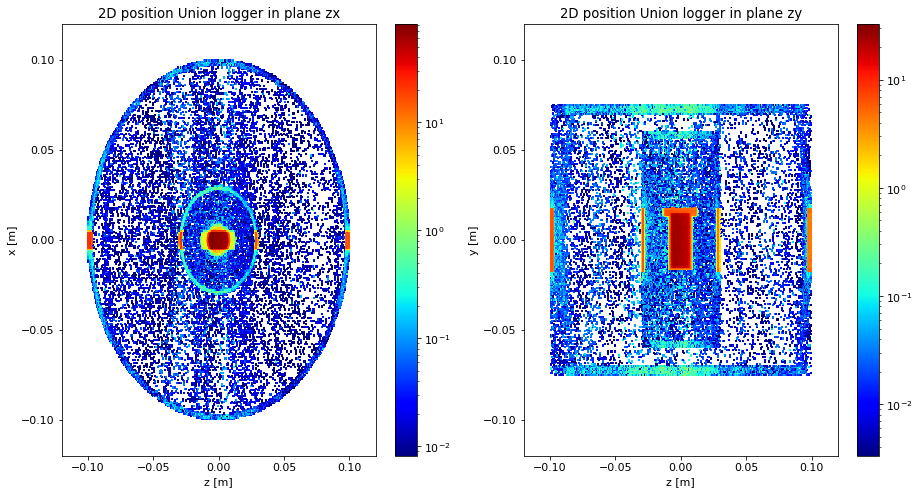

In [7]:
plotter.make_sub_plot(data, log=True, orders_of_mag=4)

### Interpreting the data
The zx logger views the cryostat from the top, while the zy loggers shows it from the side. These are histograms of scattered intensity, and it is clear the majority of the scattering happens in the direct beam. There are however scattering events in all parts of our mock cryostat, as neutrons that scattered in either the sample or cryostat walls could go in any direction due to the incoherent scattering. The aluminium and sample also have powder scattering, so some patterns can be seen from the debye scherrer cones.

## Logger targets
It is possible to attach a logger to a certain geometry, or even a list of geometries using the *target_geometry* parameter. In that way one can for example view the scattering in the sample environment, while ignoring the sample. It is also possible to select a number of specific scattering processes to investigate with the *target_process* parameter. This is especially useful when working with a single crystal process, that only scatters when the Bragg condition is met.

Let us modify our existing loggers to view certain parts of the simulated system, and then rerun the simulation.  If mpi is installed, one can add mpi=N where N is the number of cores available to speed up the simulation.

In [8]:
logger_zx.target_geometry = '"outer_cryostat_wall,cryostat_wall"'
logger_zy.target_geometry = '"sample_geometry"'

data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_loggers_119"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


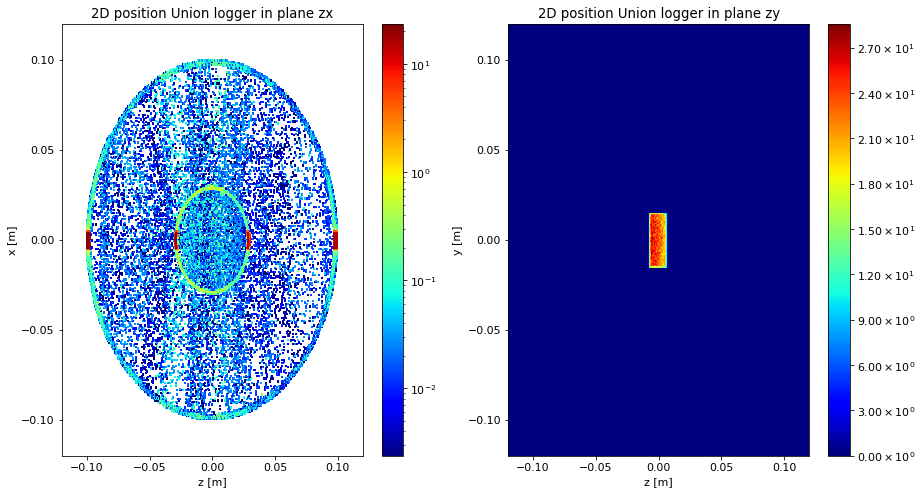

In [9]:
plotter.make_sub_plot(data, log=[True, False], orders_of_mag=4)

## Scattering order
All loggers also have the option to only record given scattering orders. For example only record the second scattering.
- order_total : Match given number of scattering events, counting all scattering events in the system
- order_volume : Match given number of scattering events, only counting events in the current volume
- order_volume_process : Match given number of scattering events, only counting events in current volume with current process

We can modify our previous loggers to test out these features. The zx logger viewing from above will keep the target, but we remove the sample target on the zy logger, which is done by setting the *taget_geometry* to NULL. We choose to look at the second scattering event.

In [10]:
logger_zx.order_total = 2

logger_zy.target_geometry = '"NULL"'
logger_zy.order_total = 2

data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_loggers_120"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


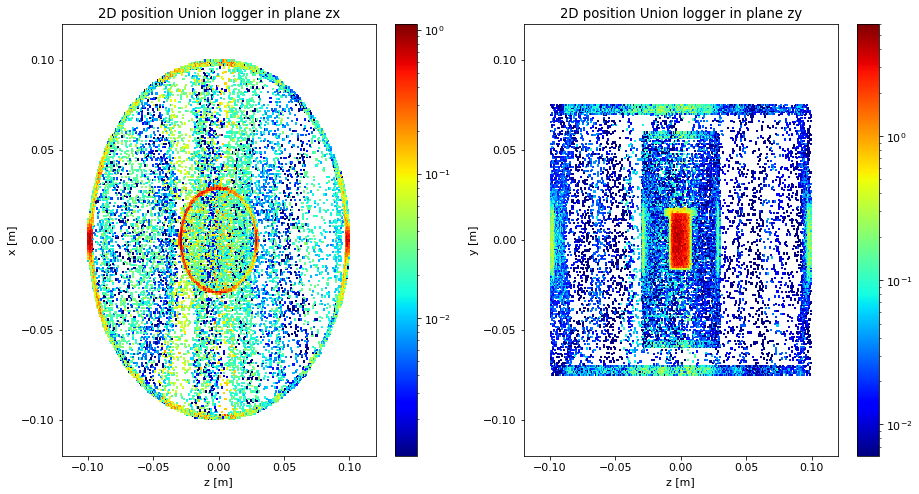

In [11]:
plotter.make_sub_plot(data, log=True, orders_of_mag=3)

## Demonstration of additional logger components
Here we add a few more loggers to showcase what kind of information that can be displayed.
- 1D logger that logs scattered intensity as function of time
- 2D abs_logger that logs absorption projected onto the scattering plane
- 2DQ logger that logs scattering vector projected onto the scattering plane
- 2D kf logger that logs final wavevector projected onto the scattering plane

In [12]:
logger_1D = instrument.add_component("logger_1D", "Union_logger_1D", before="master")
logger_1D.variable = '"time"'
logger_1D.min_value = 0.0006
logger_1D.max_value = 0.0012
logger_1D.n1 = 300
logger_1D.filename = '"logger_1D_time.dat"'

abs_logger_zx = instrument.add_component("abs_logger_space_zx", "Union_abs_logger_2D_space",
                                         before="master")
abs_logger_zx.set_AT([0,0,0], RELATIVE=sample_geometry)
abs_logger_zx.D_direction_1 = '"z"'
abs_logger_zx.D1_min = -0.12
abs_logger_zx.D1_max = 0.12
abs_logger_zx.n1 = 300
abs_logger_zx.D_direction_2 = '"x"'
abs_logger_zx.D2_min = -0.12
abs_logger_zx.D2_max = 0.12
abs_logger_zx.n2 = 300
abs_logger_zx.filename = '"abs_logger_zx.dat"'

logger_2DQ = instrument.add_component("logger_2DQ", "Union_logger_2DQ", before="master")
logger_2DQ.Q_direction_1 = '"z"'
logger_2DQ.Q1_min = -5.0
logger_2DQ.Q1_max = 5.0
logger_2DQ.n1 = 200
logger_2DQ.Q_direction_2 = '"x"'
logger_2DQ.Q2_min = -5.0
logger_2DQ.Q2_max = 5.0
logger_2DQ.n2 = 200
logger_2DQ.filename = '"logger_2DQ.dat"'

logger_2D_kf = instrument.add_component("logger_2D_kf", "Union_logger_2D_kf",
                                        before="master")
logger_2D_kf.Q_direction_1 = '"z"'
logger_2D_kf.Q1_min = -2.5
logger_2D_kf.Q1_max = 2.5
logger_2D_kf.n1 = 200
logger_2D_kf.Q_direction_2 = '"x"'
logger_2D_kf.Q2_min = -2.5
logger_2D_kf.Q2_max = 2.5
logger_2D_kf.n2 = 200
logger_2D_kf.filename = '"logger_2D_kf.dat"'

### Runnig the simulation
We now rerun the simulation with the new loggers. If mpi is installed, one can add mpi=N where N is the number of cores available to speed up the simulation.

In [13]:
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_loggers_121"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


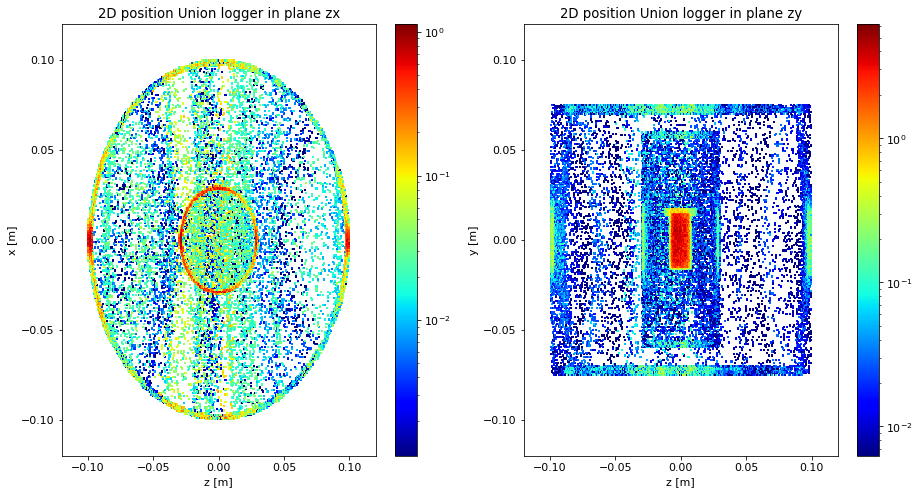

Plotting data with name logger_1D
Plotting data with name abs_logger_space_zx


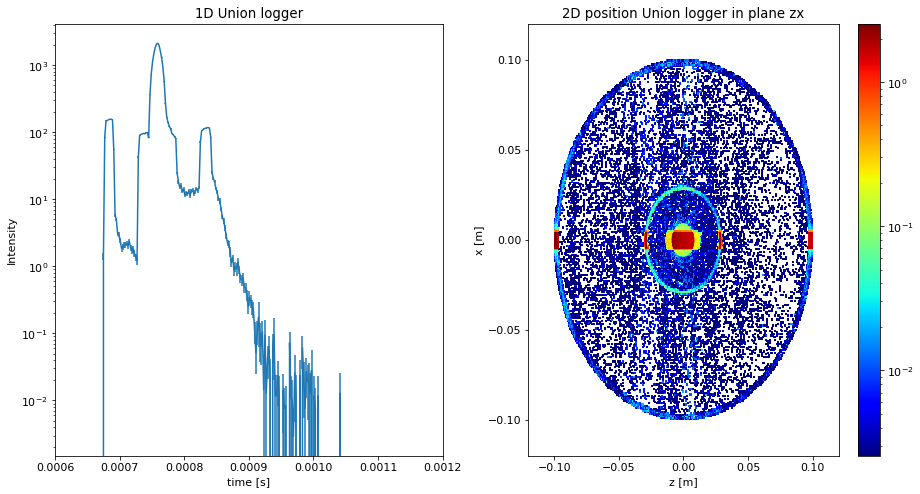

Plotting data with name logger_2DQ
Plotting data with name logger_2D_kf


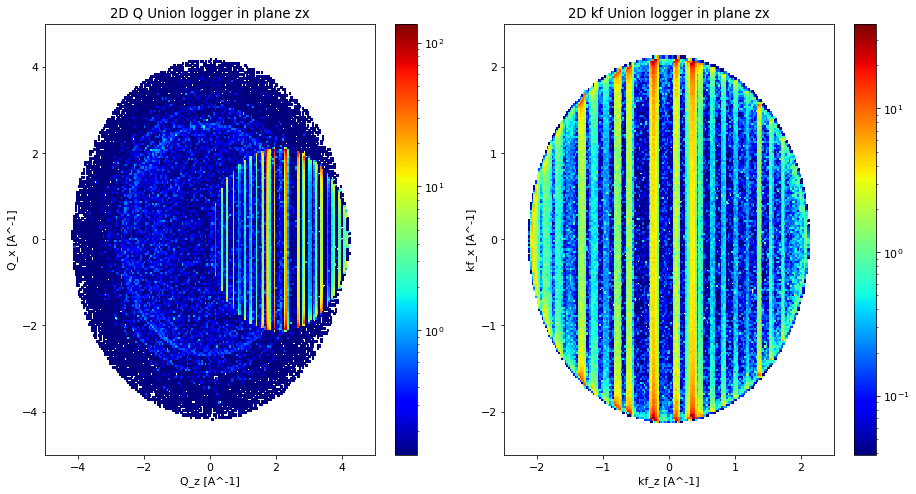

In [14]:
functions.name_plot_options("logger_space_zx", data, log=True, orders_of_mag=3)
functions.name_plot_options("logger_space_zy", data, log=True, orders_of_mag=3)
functions.name_plot_options("abs_logger_space_zx", data, log=True, orders_of_mag=3)
functions.name_plot_options("logger_1D", data, log=True, orders_of_mag=3)
functions.name_plot_options("logger_2DQ", data, log=True, orders_of_mag=3)
functions.name_plot_options("logger_2D_kf", data, log=True, orders_of_mag=3)

plotter.make_sub_plot(data[0:2])
plotter.make_sub_plot(data[2:4])
plotter.make_sub_plot(data[4:6])

## Interpreting the data
We see the scattered intensity as a function of time, here the peaks correspond to the direct beam intersecting the sides of the cryostat and sample. The source used release all neutrons at time 0, so it is a perfect pulse.

The absorption monitor shows an image very similar to the scattered intensity, but this could be very different, for example when using materials meant as shielding.

The 2D scattering vector is interesting, it shows a small sphere made of vertical lines, these are powder Bragg peaks. Since the wavevector is almost identical for all incoming neutrons, the first scattering can only access this smaller region of the space. The larger circle is incoherent scattering from second and later scattering events, where the incoming wavevector could be any direction since a scattering already happened.

The 2D final wavevector plot shows mainly the powder Bragg peaks.

## Animations and time series
Several of the Union loggers sets up more than one McStas monitor, these include:
- Union_logger_3D_space
- Union_logger_2D_space_time
- Union_logger_2D_kf_time

The Union_logger_2D_space_time for example sets up a number of Union_logger_2D_space monitors that are limited to specific time intervals. This can be used to make an animation of the monitor, which we will demonstrate here.

In [15]:
log_2D_st = instrument.add_component("logger_2D_space_time", "Union_logger_2D_space_time",
                                     before="master")

In [16]:
log_2D_st.time_bins = 36
log_2D_st.time_min = 0.0007
log_2D_st.time_max = 0.0011

log_2D_st.set_AT([0,0,0], RELATIVE=sample_geometry)
log_2D_st.D_direction_1 = '"z"'
log_2D_st.D1_min = -0.12
log_2D_st.D1_max = 0.12
log_2D_st.n1 = 300
log_2D_st.D_direction_2 = '"x"'
log_2D_st.D2_min = -0.12
log_2D_st.D2_max = 0.12
log_2D_st.n2 = 300
log_2D_st.filename = '"logger_2D_space_time.dat"'

In [17]:
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_loggers_122"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

### Creating an animation
The plotter in McStasScript can create animations when supplied with many McStasData objects. We use name_search to find all the data from the relevant logger, and then a for loop to set plot options for each of them. Then the plotter can make an animation, which is saved as a gif.

Plotting data with name logger_2D_space_time


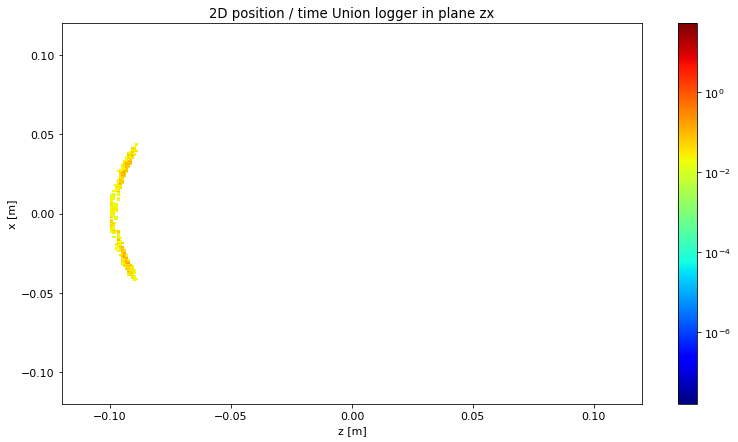

2022-03-21 15:42:16,778 WARNING:MovieWriter imagemagick unavailable; using Pillow instead.


Saving animation with filename : "animation_demo.gif"


In [18]:
ani_data = functions.name_search("logger_2D_space_time", data)
for frame in ani_data:
    frame.set_plot_options(log=True, colormap="jet")
    
plotter.make_animation(ani_data, filename="animation_demo", fps=2)

## Viewing the animation
Some problem in the jupyter notebook prevents playing the gif directly, but it can be played from markdown. One has to refresh this cell when a new animation is written. It should be visible that the beam enters the cryostat from the left, scatters of the sample and illuminates the entire cryostat. Running this simulation with a larger ncount and more time_bins in the monitor will reveal more details in what happens. This is available below, but commented out as the simulation can take some time.

![SegmentLocal](animation_demo.gif "Animation")

### Optional: Increasing resolution
Running this simulation with a larger ncount and more time_bins in the monitor will reveal more details in what happens. This is available below, but commented out as the simulation can take some time.

In [19]:
log_2D_st.time_bins = 128
instrument.settings(ncount=2E8, mpi=4)
#data = instrument.backengine()

In [20]:
#ani_data = functions.name_search("logger_2D_space_time", data)
#for frame in ani_data:
#    frame.set_plot_options(log=True, colormap="jet", orders_of_mag=6)
#    
#plotter.make_animation(ani_data, filename="animation_demo_long", fps=5)

## Viewing the animation
In the longer animation it is more evident that scattering from the aluminium hits the top and bottom of the outer cylinder.

![SegmentLocal](animation_demo_long.gif "Animation")